In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# Very hacky, bad thing to do.
SRC_PATH = os.path.realpath('../src')
sys.path.append(SRC_PATH)

In [3]:
# Local imports.
from analysis import single_cycles
from defaults import PITCH_RATE, SAMPLE_RATE
from synthesis import EnvelopeMorpher, StimulusGenerator
from util import midi_to_hz, time_plot, stft_plot

In [4]:
# Synthesis parameters.
num_partials = 70
midi_pitch = 48
fm_depth = 0.1314
f0 = midi_to_hz(midi_pitch)

In [15]:
# Load env as linear amplitude. (CheapTrick calculates the power spectrum.)
env = single_cycles[0]['env']
env = np.sqrt(env)

## Experimental stimuli

The stimuli in this notebook are built off of the spectral envelopes from one cycle of vibrato, measured using the CheapTrick algorithm. In this case, the analysis is of a cello note playing C2. 

This notebook demonstates the following stimuli types:

**BASIC**
: A looped cycle of vibrato with frequency modulation.

**FROZEN**
: Spectral envelope modulation only, no frequency modulation.

**Phase-shuffled**
: Like the frozen condition, but partial amplitude cycles are randomly shuffled in phase.

**RAP**
: Based on an average spectral envelope, each partial is modulated at the same base-rate with a random phase, at a random gain-depth between 0 – `max_depth` in dB's. The default is 10dB.

**RAF**
: Random modulation frequency. Each partial is modulated at a random rate (between 4 – 12 Hz by default).

**PAM**
: Pure amplitude modulation. Makes a static signal based on the average spectral envelope, but modulates it with the amplitude of what *would be* the resulting stimulus. Very subtle.

### Global settings

- `fm_depth` is the depth of frequency modulation in semitones.
- `num_partials` is the number of additive harmonic components in the synthesis.
- `length` is the length of the stimulus in seconds.
- `mod_rate` determines the cycle rate of the block of envelopes (in Hz).
- `mod_hold` is the time, in seconds, before the modulation starts.
- `mod_fade` is the ramp time, in seconds, to reach peak modulation depth.

Plain envelope


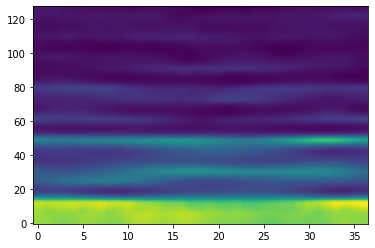

Shuffled envelope


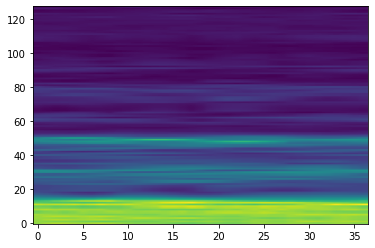

In [16]:
# Modify the spectral envelopes.

morpher = EnvelopeMorpher(env)
print('Plain envelope')
morpher.show(zoom=8)

print('Shuffled envelope')
morpher.shuffle_phase(num_shifts=4)
morpher.show(zoom=8)

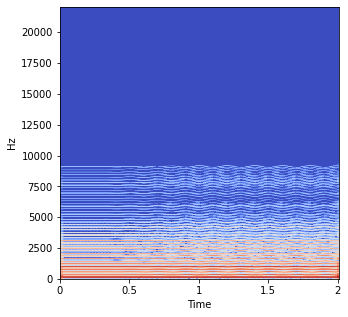

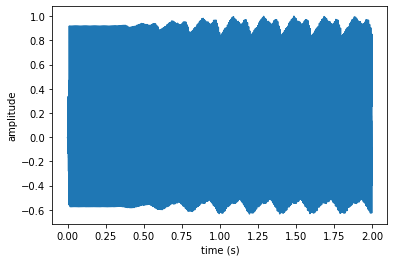

In [17]:
generator = StimulusGenerator(sr=SAMPLE_RATE, pr=PITCH_RATE)

# BASIC stimulus.
x = generator(
    f0=f0,
    fm_depth=0.1314,
    env=env,
    num_partials=70,
    length=2.,
    mod_rate=5.,
    mod_hold=0.3,
    mod_fade=0.7,
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

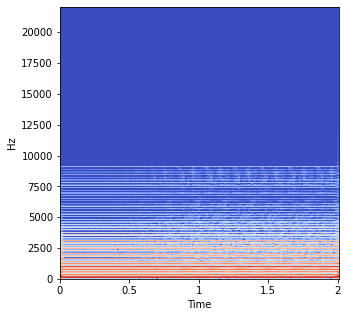

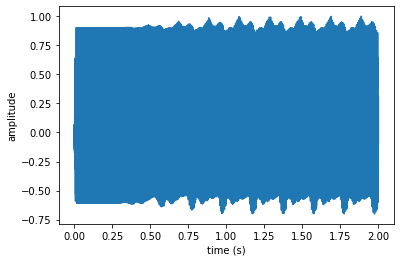

In [18]:
# FROZEN reconstruction condition (unmorphed, no FM).
x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=env,
    num_partials=70,
    length=2.,
    mod_rate=5.,
    mod_hold=0.3,
    mod_fade=0.7,
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

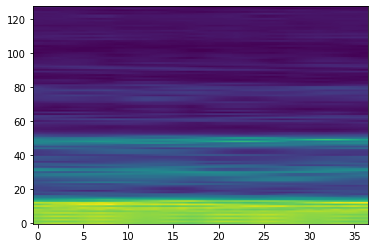

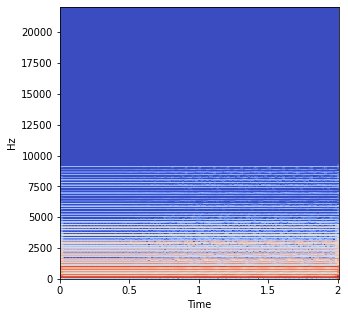

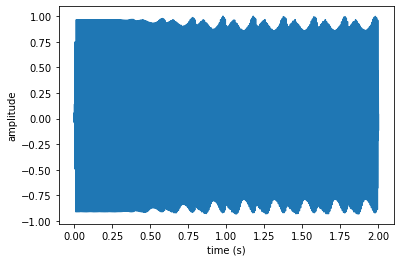

In [19]:
# Amplitude modulation phase-shuffled condition.

m1 = EnvelopeMorpher(env)
m1.shuffle_phase(num_shifts=4)
m1.show(zoom=8)

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=m1(),
    num_partials=70,
    length=2.,
    mod_rate=5.,
    mod_hold=0.3,
    mod_fade=0.7,
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

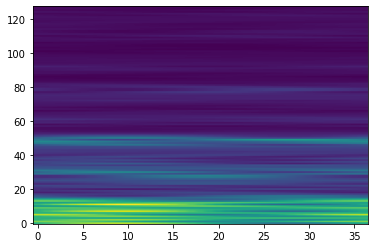

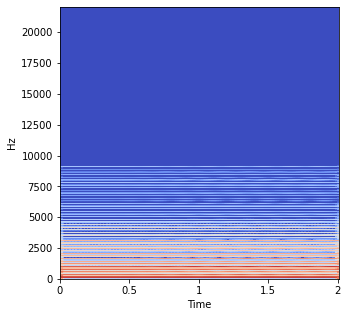

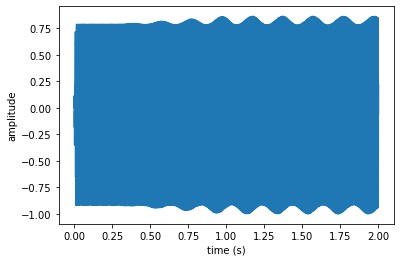

In [20]:
# Random amplitude gain and phase-shuffled condition.

m2 = EnvelopeMorpher(env)
m2.rap(max_gain=10)
m2.shuffle_phase(num_shifts=4)
m2.show(zoom=8)

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=m2(),
    num_partials=70,
    length=2.,
    mod_rate=5.,
    mod_hold=0.3,
    mod_fade=0.7,
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

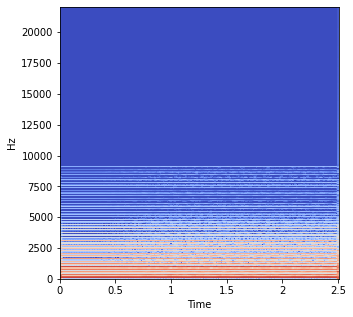

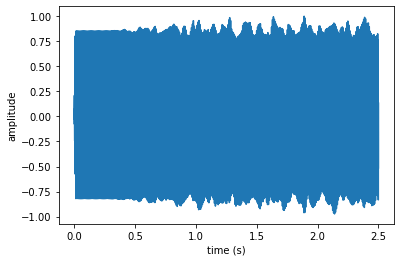

In [21]:
# Random amplitude modulation RATE condition (RAF).

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=morpher(),
    num_partials=70,
    length=2.5,
    mod_rate=5.,
    mod_hold=0.3,
    mod_fade=0.7,
    synth_mode='raf',
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))

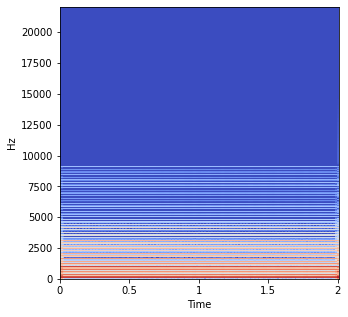

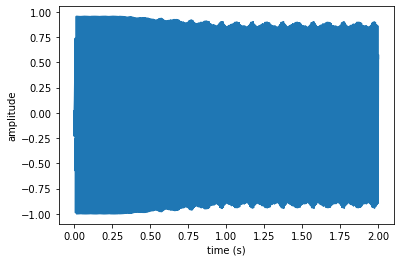

In [22]:
# PAM mode, pure amplitude modulation condition (a.k.a. tremolo).

x = generator(
    f0=f0,
    fm_depth=fm_depth*0,
    env=env,
    num_partials=70,
    length=2.,
    mod_rate=5.,
    mod_hold=0.3,
    mod_fade=0.7,
    synth_mode='pam',
)

stft_plot(x)
time_plot(x)
display(ipd.Audio(x, rate=SAMPLE_RATE))